In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Calculating the relative hydration energy of NaCl to water

## View trace of energy and gradient

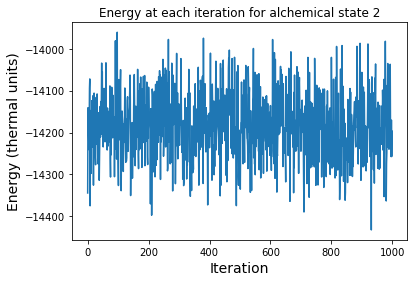

In [2]:
state = 2
energy = np.load('state_{0}/alchemical_energies.npy'.format(state))

plt.plot(energy[:,state])
plt.title('Energy at each iteration for alchemical state {0}'.format(state))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy (thermal units)', fontsize=14)
plt.show()

In [7]:
np.mean(energy, axis=0).shape

(30,)

In [12]:
nstates = 30
mean_energy = np.zeros(nstates)
for k in range(nstates):
    energies = np.load('state_{0}/alchemical_energies.npy'.format(state))[1:,:]
    mean_energy[k] = np.mean(energies, axis=0)[k]

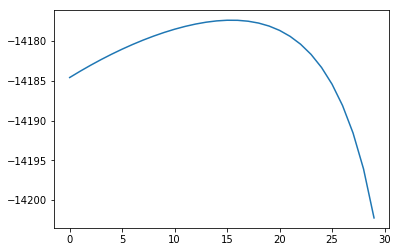

In [13]:
plt.plot(mean_energy)
plt.show()

In [15]:
mean_energy[0] - mean_energy[-1]

17.673032838927611

## Calculating the relative hydration free energy with MBAR

Unpacking the simulation data

In [16]:
nstates = 30
niterations = 1000

u_kln = np.zeros([nstates, nstates, niterations], np.float64)

for k in range(nstates):
    energies = np.load('state_{0}/alchemical_energies.npy'.format(state))[:,:]
    u_kln[k,:,:] = energies.T

Calculating the MBAR free energy.

In [17]:
from pymbar import MBAR, timeseries

# Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([nstates], np.int32) # number of uncorrelated samples
for k in range(nstates):
    [nequil, g, Neff_max] = timeseries.detectEquilibration(u_kln[k,k,:])
    indices = timeseries.subsampleCorrelatedData(u_kln[k,k,:], g=g)
    N_k[k] = len(indices)
    u_kln[k,:,0:N_k[k]] = u_kln[k,:,indices].T
# Compute free energy differences and statistical uncertainties
mbar = MBAR(u_kln, N_k)
[DeltaF_ij, dDeltaF_ij, Theta_ij] = mbar.getFreeEnergyDifferences()

print('Relative MBAR free energy = {0} +/- {1}'.format(DeltaF_ij[0,:][-1], dDeltaF_ij[0,:][-1]))

Relative MBAR free energy = -20.404238085519257 +/- 0.07762833962934927


In kcal/mol:

In [18]:
DeltaF_ij[0,:][-1]*0.592

-12.0793089466274

## Calculating the relative hydration free energy with TI

In [20]:
nstates=30
ninterations = 1000

gradients = np.zeros((nstates, ninterations))
for state in range(nstates):
    gradients[state,:] = np.load('state_{0}/alchemical_grads.npy'.format(state))[:, state]

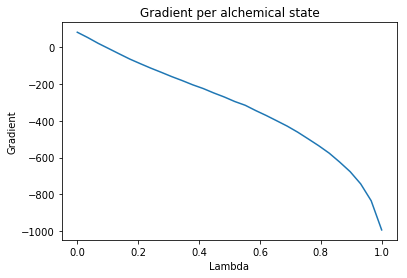

In [21]:
g_means = np.mean(gradients, axis=1)
l = np.arange(0.0, 30.0, 1.0)
l = l / np.max(l)

plt.plot(l, g_means,)
plt.title('Gradient per alchemical state')
plt.xlabel('Lambda')
plt.ylabel('Gradient')
plt.show()

Estimate the TI free energy and error with bootstrap sampling

In [22]:
from scipy import integrate
from scipy.interpolate import interp1d

nboots = 200

free_energies_trap = np.zeros(nboots)
free_energies_cubic = np.zeros(nboots)

for b in range(nboots):
    boot_samps = np.zeros((nstates, ninterations))
    for state in range(nstates):
        boot_samps[state,:] = np.random.choice(gradients[state,:], size=ninterations, replace=True)
    boot_mean = np.mean(boot_samps, axis=1)
    # Calculate area using trapezium method
    free_energies_trap[b] = np.trapz(y=boot_mean, x=l)
    # Calculate area via cubic interpolation
    fitted_grad = interp1d(l, boot_mean, kind='cubic')
    free_energies_cubic[b] = integrate.quad(fitted_grad, a=0.0, b=1.0)[0]


In [23]:
print('Cubic interpolation TI free energy = {0} +/- {1}'.format(free_energies_cubic.mean(), free_energies_cubic.std()))
print('Trapezium TI free energy = {0} +/- {1}'.format(free_energies_trap.mean(), free_energies_trap.std()))

Cubic interpolation TI free energy = -316.9138332917357 +/- 0.19388871206226643
Trapezium TI free energy = -317.4501972956274 +/- 0.18927858419936


In kcal/mol:

In [24]:
kT = 0.598
print('Cubic interpolation TI free energy = {0:.2f} +/- {1:.2f} kcal/mol'.format(free_energies_cubic.mean() * kT, free_energies_cubic.std() * kT))
print('Trapezium TI free energy = {0:.2f} +/- {1:.2f}'.format(free_energies_trap.mean() * kT, free_energies_trap.std() * kT))

Cubic interpolation TI free energy = -189.51 +/- 0.12 kcal/mol
Trapezium TI free energy = -189.84 +/- 0.11


## Estimating the thermodynamic length of the path

In [12]:
nstates=30
l = np.arange(1.0, 31.0, 1.0) / 30.0
l = l / np.max(l)
gradients = np.zeros((nstates, 999))
fisher = np.zeros(nstates)
for state in range(nstates):
    g = np.load('state_{0}/alchemical_grads.npy'.format(state))[1:, state]
    gradients[state,:] = g
    fisher[state] = np.var(g)
    if g.mean() == 0:
        print(state)
    #energies = np.load('state_{0}/alchemical_grads.npy'.format(state))[i:f,state]

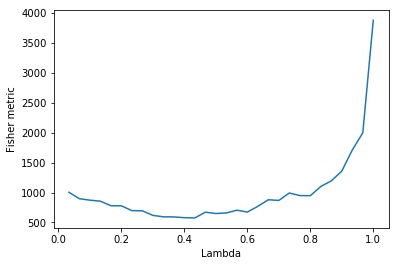

In [13]:
plt.plot(l, fisher)
plt.ylabel('Fisher metric')
plt.xlabel('Lambda')
plt.show()

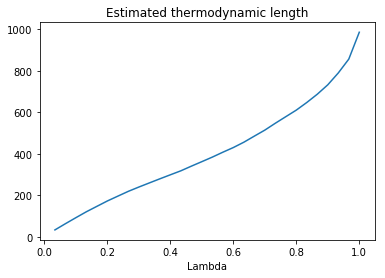

In [14]:
plt.plot(l, np.diff(l)[0] * np.cumsum(fisher))
plt.title('Estimated thermodynamic length')
plt.xlabel('Lambda')
plt.show()

In [21]:
l

array([ 0.        ,  0.03448276,  0.06896552,  0.10344828,  0.13793103,
        0.17241379,  0.20689655,  0.24137931,  0.27586207,  0.31034483,
        0.34482759,  0.37931034,  0.4137931 ,  0.44827586,  0.48275862,
        0.51724138,  0.55172414,  0.5862069 ,  0.62068966,  0.65517241,
        0.68965517,  0.72413793,  0.75862069,  0.79310345,  0.82758621,
        0.86206897,  0.89655172,  0.93103448,  0.96551724,  1.        ])